# Fabrication-Aware Inverse Design (FAID) of a Wavelength Division Multiplexer

This notebook extends the [Adjoint Optimization of a Wavelength Division Multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd9WDM/) by incorporating fabrication awareness into the design process. Specifically, we integrate a differentiable computer vision model from [PreFab Photonics](https://www.prefabphotonics.com/) into the topology optimization loop to predict and optimize the manufacturability of photonic device designs. This approach, known as *fabrication-aware inverse design* (FAID), results in devices that are inherently more robust to fabrication variations.

Unlike optical proximity correction (OPC), which adjusts designs to compensate for lithography-induced distortions after the design phase, FAID directly optimizes for manufacturable designs by using fabrication predictions within the design loop. While OPC can enhance design fidelity, it may not ensure manufacturability for complex features. FAID focuses on creating features that are inherently realizable by the fabrication process, leading to designs that are more practical to manufacture.

For a deeper look at the FAID concept, refer to this [paper](https://arxiv.org/abs/2410.07353) by Lukas Chrostowski's group at the University of British Columbia. Additional information on PreFab's virtual nanofabrication models can be found in the [PreFab documentation](https://docs.prefabphotonics.com/).

In [1]:
import autograd as ag
import autograd.numpy as anp
import matplotlib.pylab as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

np.random.seed(2)

## PreFab Setup

First, we will need to install the latest PreFab Python package.

In [2]:
%pip install --upgrade prefab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.0/921.0 kB 24.6 MB/s eta 0:00:00
  Attempting uninstall: gdstk
    Found existing installation: gdstk 0.9.50
    Uninstalling gdstk-0.9.50:
      Successfully uninstalled gdstk-0.9.50

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


PreFab models operate on a cloud platform. To make prediction requests, you must first create an account. Run the following cell or visit the [PreFab website](https://www.prefabphotonics.com/signup) to create an account.

In [3]:
import webbrowser

_ = webbrowser.open("https://www.prefabphotonics.com/signup")

To associate your account, a token is required. This action will prompt a browser window to open, allowing you to log in and authenticate your token.

In [4]:
!python3 -m prefab setup

/usr/local/bin/python3: No module named prefab


Lastly, to verify that PreFab is properly configured, we can make a test prediction request.

From the test prediction results below, we can see how the predicted structure undergoes corner rounding and loss of small features, as expected from the fabrication process.


Prediction: 100%|██████████████████████████████| 100/100 [00:04<00:00,  


<Axes: xlabel='x (nm)', ylabel='y (nm)'>

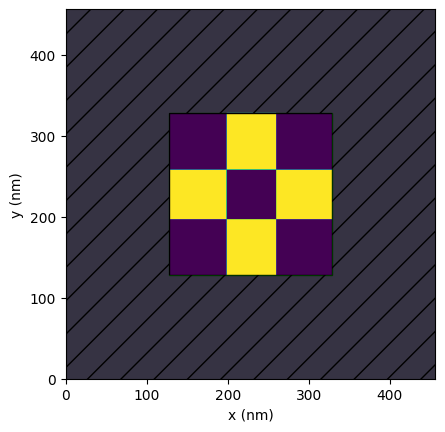

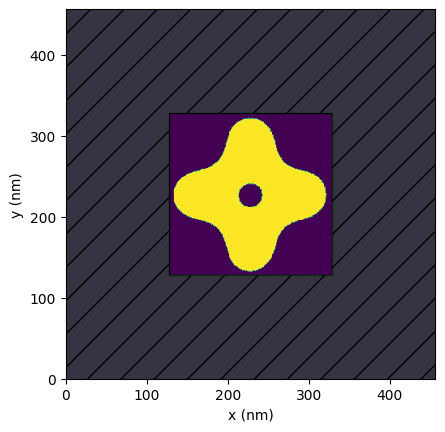

In [5]:
import prefab as pf

device = pf.shapes.target()
prediction = device.predict(model=pf.models["ANT_NanoSOI_ANF1_d10"], binarize=True)
device.plot()
prediction.plot()

## Predicting Device Performance

Using the prediction model, we can simulate the expected experimental performance of device designs such as the wavelength division multiplexer (WDM) in the [Adjoint Optimization of a Wavelength Division Multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd9WDM/). The WDM was optimized with a relatively large feature size and an erosion/dilation penalty to enhance robustness against fabrication variations. This optimization allows it to tolerate predicted fabrication variations quite well; however, some performance degradation is still observed. As illustrated in the figure below, the fabrication-predicted transmission spectra gets distorted, insertion loss is increased, and further crosstalk is introduced. This performance degradation can be mitigated with FAID.

# ![WDM performance without fabrication prediction](img/flux_ID_nopredict.png)
# ![WDM performance with fabrication prediction](img/flux_ID_predict.png)



## Sim Setup

Then we set up our basic simulation for the FAID optimization.

We have an input waveguide connected to a square design region, which has `n=4` output waveguides. 

The square design region is a custom medium with a pixelated permittivity grid that we wish to optimize such that input light of different wavelengths get directed to different output ports.

As this is a SOI device, we typically define the design region and waveguides as Silicon sitting on an SiO2 substrate. For this demo, we make a 2D simulation, but it can be easily made 3D by changing the `Lz` parameter, adding dimension to the structures, and adding a substrate.

In [6]:
# material information
n_si = 3.49
n_sio2 = 1.45  # not used in 2D
n_air = 1

# channel wavelengths
wvls_design = np.array([1.270, 1.290, 1.310, 1.330])

freqs_design = td.C_0 / wvls_design
num_freqs_design = len(freqs_design)
freq_max = np.max(freqs_design)
freq_min = np.min(freqs_design)
keys = [str(i) for i in range(num_freqs_design)]
df_design = abs(np.mean(np.diff(freqs_design)))

# forward source
freq0 = np.mean(freqs_design)
wvl0 = td.C_0 / freq0
fwidth = freq_max - freq_min
run_time = 120 / fwidth

# we average the metrics over the channels with some frequency width
channel_fwidth = df_design / 2.0
channel_bounds = [
    (f - channel_fwidth / 2, f + channel_fwidth / 2) for f in freqs_design
]
num_freqs_channel = 5
channel_freqs = []
for fmin, fmax in channel_bounds:
    sub_freqs = np.linspace(fmin, fmax, num_freqs_channel)
    channel_freqs += sub_freqs.tolist()

# size of design region
lx = 4.5
ly = 4.5
ly_single = ly / num_freqs_design
lz = td.inf

# size of waveguides
wg_width = 0.3
wg_length = 1.5
wg_spacing = 0.8

# spacing between design region and PML in y
buffer = 1.5

# size of simulation
Lx = lx + wg_length * 2
Ly = ly + buffer * 2
Lz = 0.0

# fabrication constraints (feature size and projection strength)
radius = 0.100
beta0 = 2

# resolution information
min_steps_per_wvl = 18
dl_design_region = 0.015

### Static Simulation

First, we'll define the simulation without any design region using the "static" components that dont change over the optimization.

In [7]:
# define the waveguide ports
wg_in = td.Structure(
    geometry=td.Box(
        center=(-Lx / 2, 0, 0),
        size=(wg_length * 2, wg_width, lz),
    ),
    medium=td.Medium(permittivity=n_si**2),
)

centers_y = np.linspace(
    -ly / 2.0 + ly_single / 2.0, +ly / 2.0 - ly_single / 2.0, num_freqs_design
)
mode_size = (0, 0.9 * ly_single, td.inf)

wgs_out = []
for center_y in centers_y:
    wg_out = td.Structure(
        geometry=td.Box(
            center=(+Lx / 2, center_y, 0),
            size=(wg_length * 2, wg_width, lz),
        ),
        medium=td.Medium(permittivity=n_si**2),
    )
    wgs_out.append(wg_out)

# measure the mode amplitudes at each of the output ports
mnts_mode = []
for key, center_y in zip(keys, centers_y):
    mnt_mode = td.ModeMonitor(
        center=(Lx / 2 - wg_length / 2, center_y, 0),
        size=mode_size,
        freqs=channel_freqs,
        mode_spec=td.ModeSpec(),
        name=f"mode_{key}",
    )
    mnts_mode.append(mnt_mode)

# measures the flux at each of the output ports
mnts_flux = []
for key, center_y in zip(keys, centers_y):
    mnt_flux = td.FluxMonitor(
        center=(Lx / 2 - wg_length / 2, center_y, 0),
        size=mode_size,
        freqs=channel_freqs,
        name=f"flux_{key}",
    )
    mnts_flux.append(mnt_flux)

# and a field monitor that measures fields on the z=0 plane at the design freqs
fld_mnt = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    freqs=freqs_design,
    name="field",
)

# inject the fundamental mode into the input waveguide
mode_src = td.ModeSource(
    center=(-Lx / 2 + wg_length / 2, 0, 0),
    size=mode_size,
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth,
    ),
    direction="+",
    mode_index=0,
)

sim_static = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl,
        wavelength=np.min(wvls_design),
    ),
    structures=[wg_in] + wgs_out,
    sources=[mode_src],
    monitors=mnts_mode + mnts_flux + [fld_mnt],
    boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=True if Lz else False),
    run_time=run_time,
)

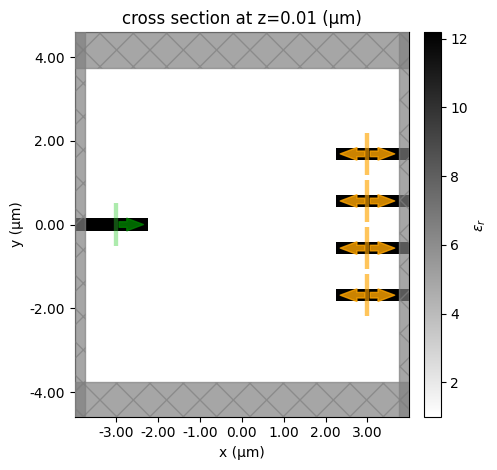

In [8]:
ax = sim_static.plot_eps(z=0.01)
ax.set_aspect("equal")

### Solving modes

Next, we want to ensure that we are injecting and measuring the right waveguide modes at each of the ports.

We'll use `tidy3d`'s `ModeSolver` to analyze the modes of our input waveguide.

In [9]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver

# we'll ask for 4 modes just to inspect
num_modes = 4

# let's define how large the mode planes are and how far they are from the PML relative to the design region
mode_size = (0, ly_single, td.inf)

# make a plane corresponding to where we wish to measure the input mode
plane_in = td.Box(
    center=(-Lx / 2 + wg_length / 2.0, 0, 0),
    size=mode_size,
)

mode_solver = ModeSolver(
    simulation=sim_static,
    plane=plane_in,
    freqs=freqs_design,
    mode_spec=td.ModeSpec(num_modes=num_modes),
)

Next we run the mode solver on the servers.

In [ ]:
mode_data = run_mode_solver(
    mode_solver, reduce_simulation=True, results_file="data/mode_solver.hdf5"
)

10:44:30 EST Mode solver created with                                           
             task_id='fdve-be935b1a-2455-4abb-8028-a29789492be1',               
             solver_id='mo-e34389bd-0e8e-4503-b54d-a1a91ca50e90'.

Output()

Output()

10:44:33 EST Mode solver status: queued

10:45:19 EST Mode solver status: running

And visualize the results.

In [ ]:
fig, axs = plt.subplots(num_modes, 3, figsize=(12, 12), tight_layout=True)
for mode_index in range(num_modes):
    vmax = 1.1 * max(
        abs(mode_data.field_components[n].sel(mode_index=mode_index)).max()
        for n in ("Ex", "Ey", "Ez")
    )
    for field_name, ax in zip(("Ex", "Ey", "Ez"), axs[mode_index]):
        for freq in freqs_design:
            key = f"{td.C_0 / freq * 1000 :.0f} nm"
            field = mode_data.field_components[field_name].sel(
                mode_index=mode_index, f=freq
            )
            field.real.plot(label=f"Real ({key})", ax=ax)
            field.imag.plot(ls="--", label=f"Imag ({key})", ax=ax)
        ax.set_title(f"index={mode_index}, {field_name}")
        ax.set_ylim(-vmax, vmax)
        ax.legend()

print("Effective index of computed modes: ", np.array(mode_data.n_eff))

We identify `mode_index=0` as the first order mode that is out of plane of the device. Let's choose to optimize our device with respect to this as the mode of interest for both the input and output.

We'll update or static simulation with the new mode index and mode specificiation, in case these are different from the original ones.

In [ ]:
mode_index = 0
mode_spec = td.ModeSpec(num_modes=mode_index + 1)

sim_static = sim_static.updated_copy(mode_index=mode_index, path="sources/0")
sim_static = sim_static.updated_copy(mode_spec=mode_spec, path="sources/0")
for i in range(num_freqs_design):
    sim_static = sim_static.updated_copy(mode_spec=mode_spec, path=f"monitors/{i}")

### Define design region

Next, we define the design region as a pixelated grid of permittivity values that get generated from our optimization parameters.

We first define the overall geometry as a `td.Box` and also the number of pixels in x and y staticd on our design region resolution.

In [ ]:
nx = int(lx / dl_design_region)
ny = int(ly / dl_design_region)

design_region_geo = td.Box(size=(lx, ly, lz), center=(0, 0, 0))

PreFab models function on a grid with a 1 nm resolution. To use the prediction function effectively, we adjust our simulation design region to match this resolution. We also add a buffer layer to the design region to account for the interface between it and the waveguides. Afterward, we will convert it back to the original size and resolution.

While this process introduces discretization error, it can be minimized by using a higher simulation resolution—which is recommended for production designs.

> **Note:** We'll use a model for the electron-beam lithography process from [Applied Nanotools Inc. (ANT)](https://www.appliednt.com/) for the prediction.

In [ ]:
FAB_MODEL = pf.models["ANT_NanoSOI_ANF1_d10"]
prediction_buffer = 0.16
n_prediction_buffer = int(prediction_buffer / dl_design_region)


def resize_array(array: np.ndarray, scale: float) -> np.ndarray:
    H, W = array.shape
    """Array resizing using bilinear interpolation."""
    new_H = int(H * scale)
    new_W = int(W * scale)

    x = anp.linspace(0, W - 1, new_W)
    y = anp.linspace(0, H - 1, new_H)
    x_grid, y_grid = anp.meshgrid(x, y)

    x0 = anp.floor(x_grid).astype(int)
    x1 = x0 + 1
    y0 = anp.floor(y_grid).astype(int)
    y1 = y0 + 1

    x0 = anp.clip(x0, 0, W - 1)
    x1 = anp.clip(x1, 0, W - 1)
    y0 = anp.clip(y0, 0, H - 1)
    y1 = anp.clip(y1, 0, H - 1)

    Ia = array[y0, x0]
    Ib = array[y1, x0]
    Ic = array[y0, x1]
    Id = array[y1, x1]

    wa = (x1 - x_grid) * (y1 - y_grid)
    wb = (x1 - x_grid) * (y_grid - y0)
    wc = (x_grid - x0) * (y1 - y_grid)
    wd = (x_grid - x0) * (y_grid - y0)

    resized_image = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return resized_image


def add_prediction_buffer(params):
    """Add a buffer layer to the design region. This is useful for predicting the interface between the design region and the waveguides."""
    params = anp.pad(
        params, pad_width=n_prediction_buffer, mode="constant", constant_values=0
    )
    wg_mask = anp.zeros_like(params)
    center_y_mask = wg_mask.shape[0] // 2

    # add input waveguide to mask
    wg_half_width = int((wg_width / 2) / dl_design_region)
    wg_mask[
        0:n_prediction_buffer,
        center_y_mask - wg_half_width : center_y_mask + wg_half_width,
    ] = 1

    # add output waveguides to mask
    for center_y in centers_y:
        wg_center = int(center_y / dl_design_region)
        wg_mask[
            -n_prediction_buffer:,
            center_y_mask + wg_center - wg_half_width : center_y_mask
            + wg_center
            + wg_half_width,
        ] = 1

    return params * (1 - wg_mask) + wg_mask


def params_to_device_array(
    params: np.ndarray, scale: float, pad_width: int = 100
) -> np.ndarray:
    """Convert params to a device array at 1 nm resolution."""
    params = add_prediction_buffer(params)
    device_array = resize_array(params, scale)
    return device_array


def device_array_to_params(
    device_array: np.ndarray, scale: float, pad_width: int = 100
) -> np.ndarray:
    """Convert device array to params at the original resolution."""
    params = resize_array(device_array, 1 / scale)
    params = params[
        n_prediction_buffer:-n_prediction_buffer,
        n_prediction_buffer:-n_prediction_buffer,
    ]
    return params

Next we write a function to give us the pixelated array as a function of our parameters through our filtering and projection methods, which are used to make the resulting structures easier to fabricate. For more details, refer to our 4th lecture in the [inverse design 101 lecture series](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/), which focuses on fabrication constraints.

We also wrap this function in another one that generates the entire `td.Structure` corresponding to the design region, for convenience later.

> **For FAID:** During each iteration, we predict the fabrication variation of the structure and incorporate the new geometry into the simulation. This approach allows us to optimize a "virtual" structure, which accounts for fabrication imperfections, rather than an idealized version. We introduce a `use_predict` flag here.

In [ ]:
from tidy3d.plugins.autograd import make_filter_and_project, rescale

filter_project = make_filter_and_project(radius, dl_design_region)


def get_density(params: np.ndarray, beta: float) -> np.ndarray:
    """Get the density of material (0, 1) as a function of the parameters (0,1)"""
    return filter_project(params, beta=beta)


def make_eps(params: np.ndarray, beta: float, use_predict: bool = False) -> np.ndarray:
    """Generates permittivity values for the design region, optionally using a PreFab prediction model to account for manufacturing variations."""
    density = get_density(params, beta=beta)

    # ********** START OF ADDED PREFAB CODE **********
    if use_predict:
        device_array = params_to_device_array(density, dl_design_region * 1000)
        prediction_array = pf.predict.predict_array_with_grad(device_array, FAB_MODEL)
        predicted_density = device_array_to_params(
            prediction_array, dl_design_region * 1000
        )
        return rescale(predicted_density, 1, n_si**2)
    # ********** END OF ADDED PREFAB CODE **********

    else:
        return rescale(density, 1, n_si**2)


def make_custom_medium(
    params: np.ndarray, beta: float, use_predict: bool = False
) -> td.Structure:
    """Make td.Structure containing custom medium with the permittivity data as a function of parameters."""
    eps = make_eps(params, beta, use_predict).reshape((nx, ny, 1))
    xs = anp.linspace(-lx / 2, lx / 2, nx)
    ys = anp.linspace(-ly / 2, ly / 2, ny)
    zs = [0]
    coords = dict(x=xs, y=ys, z=zs)

    eps_arr = td.ScalarFieldDataArray(data=eps, coords=coords)

    medium = td.CustomMedium(permittivity=eps_arr)

    return td.Structure(geometry=design_region_geo, medium=medium)

### Construct Simulation

With all of these functions and variables defined, we can write a single function to return our "static" `td.Simulation` as a function of our design parameters. This function first constructs the design region, a mesh override structure to control the resolution in this region, and then creates a copy of the original `td.Simulation` with all of the basic parameters.

In [ ]:
def get_sim(params, beta, include_extra_mnts: bool = True, use_predict: bool = False):
    design_region = make_custom_medium(params, beta=beta, use_predict=use_predict)

    design_override = td.MeshOverrideStructure(
        geometry=design_region.geometry,
        dl=[dl_design_region, dl_design_region, dl_design_region],
    )
    grid_spec = sim_static.grid_spec.updated_copy(
        override_structures=list(sim_static.grid_spec.override_structures)
        + [design_override]
    )

    update_dict = dict(
        structures=list(sim_static.structures) + [design_region],
        grid_spec=grid_spec,
    )

    # if include_extra_mnts is False, update sim to only include mode monitors, to save data.
    if not include_extra_mnts:
        update_dict["monitors"] = mnts_mode

    return sim_static.updated_copy(**update_dict)

Let's test out our function. We'll make an initially random array of parameters between 0 and 1 and generate the static simulation to plot and inspect.

In [ ]:
params0 = np.random.random((nx, ny))
sim0 = get_sim(params0, beta=beta0, use_predict=False)

In [ ]:
ax = sim0.plot_eps(z=0.01)
ax.set_aspect("equal")

## Defining Objective Function

With our simulation fully defined as a function of our parameters, we are ready to define our objective function.

In this case, it is quite simple, we simply measure the transmitted power in our `n=4` output waveguide modes for each of the `n=4` design frequencies.

Our objective whenn looking at waveguide `i` will be to maximize power transmission at frequency `i`. To reduce cross talk between waveguide `i` and frequency `j != i`, we will subtract the average of the power transmissions for all of the other ports.

Our overall metric will then be the average

In [ ]:
import xarray as xr


def average_over_channel(
    spectrum: xr.DataArray, fmin: float, fmax: float
) -> xr.DataArray:
    """Get average of the spectrum within the frequency range between fmin and fmax."""
    freqs = spectrum.f
    freqs_in_channel = np.logical_and(freqs >= fmin, freqs <= fmax).values
    num_freqs = np.sum(freqs_in_channel)
    avg_power = spectrum.values @ freqs_in_channel / num_freqs
    return avg_power


def get_power(sim_data: td.SimulationData, mnt_index: int, freq_index: int) -> float:
    """Get the average power at waveguide `mnt_index` and frequency channel `freq_index`."""
    mnt_name = mnts_mode[mnt_index].name
    mnt_data = sim_data[mnt_name]
    fmin_channel, fmax_channel = channel_bounds[freq_index]
    amp = mnt_data.amps.sel(direction="+", mode_index=0)
    power_spectrum = anp.abs(amp) ** 2
    return average_over_channel(power_spectrum, fmin=fmin_channel, fmax=fmax_channel)


def get_metric(
    sim_data: td.SimulationData, mnt_index: int, leak_weight: float = 1.0
) -> float:
    """measure of how well this channel (`mnt_index`) performs. With an adjustable weight to reduce cross talk influence."""

    power_all = [
        get_power(sim_data=sim_data, mnt_index=mnt_index, freq_index=j)
        for j in range(num_freqs_design)
    ]

    power_transmitted = power_all[mnt_index]

    # remove the extra term of power_self in power_all
    power_leaked = sum(power_all) - power_transmitted
    avg_power_leaked = power_leaked / (num_freqs_design - 1)

    return power_transmitted - leak_weight * avg_power_leaked

Next we add a penalty to produce structures that are invariant under erosion and dilation, which is a useful approach to implementing minimum length scale features.

In [ ]:
from tidy3d.plugins.autograd import make_erosion_dilation_penalty

beta_penalty = 10

penalty = make_erosion_dilation_penalty(radius, dl_design_region, beta=beta_penalty)

### Total Objective function

Then we write an `objective` function that constructs our simulation, runs it, measures our metric, and subtracts our penalty.

> Note: due to current limitations of the autograd support in tidy3d, when running broadband simulations, one must have only a single output 'port' in the forward simulation. Therefore, we split our problem into one simulation per output waveguide, and then run these in parallel using `web.run_async()`.

> **For FAID:** We set `use_predict=True` and `use_penalty=False`.


In [ ]:
# useful for debugging, if you want to turn off the metric, penalty, or prediction
use_penalty = False
use_metric = True
use_predict = True


def objective(
    params, beta: float, penalty_weight: float = 1.0, leak_weight: float = 0.0
) -> float:
    metric = 0.0
    penalty_value = 0.0

    if use_metric:
        sim = get_sim(
            params, beta=beta, include_extra_mnts=False, use_predict=use_predict
        )
        simulations = {f"WDM_invdes_{key}": sim for key in keys}
        batch_data = web.run_async(simulations, verbose=False, path_dir="data/")
        metric = 0.0
        for mnt_index, (_, sim_data) in enumerate(batch_data.items()):
            metric = metric + get_metric(
                sim_data=sim_data, mnt_index=mnt_index, leak_weight=leak_weight
            )
        metric = metric / num_freqs_design

    if use_penalty:
        penalty_value = penalty(params)

    return metric - penalty_weight * penalty_value

### Differentiating the objective

Finally, we can simply use `autograd` (`ag`) to transform this objective function into a function that returns our objective function value and our gradient, which we will feed to the optimizer.th

In [ ]:
grad_fn = ag.value_and_grad(objective)

Let's try out our gradient function.

In [ ]:
J, grad = grad_fn(params0, beta=1)

In [ ]:
print(J)
print(grad.shape)
print(np.linalg.norm(grad))

## Run Optimization

Finally, we are ready to optimize our device. We will make use of the `optax` package to define an optimizer using the `adam` method, as we've done in the previous inverse design tutorials.

We record a history of objective function values, and parameters, for visualization later.

> **For FAID:** The PreFab prediction will add close to a minute to the runtime of each iteration.


In [ ]:
import os
import pickle

import optax

# check if the optimization history file exists
history_file_path = "misc/optimization_history_FAID_4ch_R100_1filter_buffer.pkl"
if os.path.exists(history_file_path):
    # load the saved optimization history
    with open(history_file_path, "rb") as f:
        data_history = pickle.load(f)
    Js = data_history["Js"]
    params_history = data_history["params_history"]
    beta_history = data_history["beta_history"]
    opt_state = data_history["opt_state"]
    start_step = len(Js)
    print(f"Loaded {start_step} steps from history file.")
    params = params_history[-1]
else:
    # initialize new optimization history
    Js = []
    params_history = [params0]
    beta_history = []
    start_step = 0
    params = 0.5 * np.ones_like(params0)
    opt_state = None

# hyperparameters
num_steps = 70
learning_rate = 0.1
beta_min = 1
beta_max = 50

# initialize the optimizer with the last known state
optimizer = optax.adam(learning_rate=learning_rate)
if opt_state is None:
    opt_state = optimizer.init(params)

for i in range(start_step, num_steps):
    perc_done = i / (num_steps - 1)

    # in case we want to change parameters over the optimization procedure
    one_third = 1.0 / 3.0

    penalty_weight = 1.0
    leak_weight = 0.0 if perc_done < one_third else 1.0
    beta_i = beta_min * (1 - perc_done) + beta_max * perc_done

    # make a plot of density to check on progress
    density = get_density(params, beta_i)
    plt.subplots(figsize=(2, 2))
    plt.imshow(np.flipud(1 - density.T), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
    plt.show()

    # compute gradient and current objective function value
    value, gradient = grad_fn(
        params, beta=beta_i, penalty_weight=penalty_weight, leak_weight=leak_weight
    )

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tbeta = {beta_i:.2f}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)
    params = np.array(params)

    # keep params between 0 and 1
    params = anp.minimum(1.0, params)
    params = anp.maximum(0.0, params)

    # save history
    Js.append(value)
    params_history.append(params)
    beta_history.append(beta_i)
    data_to_save = {
        "Js": Js,
        "params_history": params_history,
        "beta_history": beta_history,
        "opt_state": opt_state,
    }
    with open(history_file_path, "wb") as f:
        pickle.dump(data_to_save, f)

## Visualize Results

Let's visualize the results of our optimization.

### Objective function vs Iteration

First we inspect the objective function value as a function of optimization iteration number. We see that it steadily increases as expected. 

In [ ]:
plt.plot(Js)
plt.xlabel("iteration number")
plt.ylabel("objective function")
plt.show()

### Final Simulation

Let's take a look at the final simulation, without the prediction model, which we grab from our history.

In [ ]:
# we'll sample the modes at a finer frequency resolution for this final evaluation, for smoother plots
iter_final = -1

num_freqs_measure = 151
freqs_measure = np.linspace(
    freq_min - df_design, freq_max + df_design, num_freqs_measure
)

sim_final = get_sim(
    params_history[iter_final], beta=beta_history[iter_final], use_predict=False
)

for i in range(num_freqs_design):
    sim_final = sim_final.updated_copy(freqs=freqs_measure, path=f"monitors/{i}")
    sim_final = sim_final.updated_copy(
        freqs=freqs_measure, path=f"monitors/{i + num_freqs_design}"
    )

In [ ]:
ax = sim_final.plot_eps(z=0.01, monitor_alpha=0, source_alpha=0)

In [ ]:
penalty_value_final = penalty(params_history[-1])
print(penalty_value_final)

In [ ]:
sim_data_final = web.run(sim_final, verbose=False, task_name="wdm_final")

Let's also run the final simulation with the prediction model.

In [ ]:
sim_final_predicted = get_sim(
    params_history[iter_final], beta=beta_history[iter_final], use_predict=True
)

for i in range(num_freqs_design):
    sim_final_predicted = sim_final_predicted.updated_copy(
        freqs=freqs_measure, path=f"monitors/{i}"
    )
    sim_final_predicted = sim_final_predicted.updated_copy(
        freqs=freqs_measure, path=f"monitors/{i + num_freqs_design}"
    )

The predicted fabrication variations show some notable differences from the ideal design, such as the filled-in hole in the bottom left. However, most variations are quite subtle at this scale and resolution. Despite the seemingly minor geometric differences, these variations lead to meaningful changes in device performance, which we will analyze in the next section.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sim_final_predicted.plot_eps(z=0.01, monitor_alpha=0, source_alpha=0, ax=ax1)
ax1.set_title("predicted cross section at z=0.01")
sim_final.plot_eps(z=0.01, monitor_alpha=0, source_alpha=0, ax=ax2)
ax2.set_title("idealized cross section at z=0.01")
plt.show()

In [ ]:
sim_data_final_predicted = web.run(
    sim_final_predicted, verbose=False, task_name="wdm_final_predicted"
)

### Flux

Let's inspect the flux over each of the output ports as a function of wavelength.

We notice that the ports have peaks in transmission at their corresponding design wavelengths, and are supressed at the other wavelengths, as expected!

> **For FAID:** Because we optimized the design based on the fabrication-predicted geometry, we observe that the predicted design has *higher* performance than the final idealized design. This is intended. This contrasts with non-FAID-based optimization, where the fabrication-predicted structures typically have lower performance than the ideal design due to unaccounted fabrication variations.


In [ ]:
def plot_flux(sim_data, title, linestyle="-"):
    for i in range(num_freqs_design):
        freq = freqs_design[i]
        flux_data = sim_data[mnts_flux[i].name]
        wvl_nm = 1000 * td.C_0 / freq
        wavelengths_nm = 1000 * td.C_0 / np.array(flux_data.flux.f)
        flux = np.array(flux_data.flux.values)
        loss_db = 10 * np.log10(flux)
        label = f"channel @ {int(wvl_nm)} nm"
        fmin, fmax = channel_bounds[i]
        plt.gca().axvspan(1000 * td.C_0 / fmin, 1000 * td.C_0 / fmax, alpha=0.2)
        plt.plot(wavelengths_nm, loss_db, label=label, linestyle=linestyle)
        plt.scatter([wvl_nm], [0], 100, marker="*")
        plt.xlabel("wavelength (nm)")
        plt.ylabel("insertion loss (dB)")
        plt.legend()
        plt.grid("on")
    plt.title(title)
    plt.show()


plot_flux(sim_data_final_predicted, "total flux (with fabrication prediction)")
plot_flux(sim_data_final, "total flux (without fabrication prediction)", linestyle="--")


In [ ]:
def plot_power(sim_data, title, linestyle="-"):
    for i in range(num_freqs_design):
        freq = freqs_design[i]
        amps = sim_data[mnts_mode[i].name].amps
        powers = np.abs(amps.sel(direction="+", mode_index=0)) ** 2
        wvl_nm = 1000 * td.C_0 / freq
        flux_data = sim_data[mnts_flux[i].name]
        wavelengths_nm = 1000 * td.C_0 / np.array(flux_data.flux.f)
        flux = np.array(powers.values)
        loss_db = 10 * np.log10(flux)
        label = f"channel @ {int(wvl_nm)} nm"
        fmin, fmax = channel_bounds[i]
        plt.gca().axvspan(1000 * td.C_0 / fmin, 1000 * td.C_0 / fmax, alpha=0.2)
        plt.plot(wavelengths_nm, loss_db, label=label, linestyle=linestyle)
        plt.scatter([wvl_nm], [0], 100, marker="*")
        plt.xlabel("wavelength (nm)")
        plt.ylabel("insertion loss (dB)")
        plt.legend()
        plt.grid("on")
    plt.title(title)
    plt.show()


plot_power(
    sim_data_final_predicted, "power at mode_index=0 (with fabrication prediction)"
)
plot_power(
    sim_data_final,
    "power at mode_index=0 (without fabrication prediction)",
    linestyle="--",
)


### Fields

Let's also plot the field intensity patterns at each of the design wavelengths for the predicted design.

We see from this plot the expected result that the power is directed to the design port at each frequency.

In [ ]:
# plot fields at the two design wavelengths

fig, axes = plt.subplots(
    1, num_freqs_design, tight_layout=True, figsize=(15, 0.8 * num_freqs_design)
)

for freq, ax in zip(freqs_design, axes):
    sim_data_final_predicted.plot_field("field", "E", "abs^2", f=freq, ax=ax, vmax=1200)
    wvl = 1000 * td.C_0 / freq
    ax.set_title(f"wavelength = {int(wvl)} nm")

### Animation

Finally, we animate this plot as a function of iteration number. The animation shows the device quickly accomplishing our design objective.

> Note: can take a few minutes to complete

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax1 = fig, axes = plt.subplots(1, 1, tight_layout=False, figsize=(9, 4))


def animate(i):
    sim_i = get_sim(params_history[i], beta_history[i])
    sim_i.plot_eps(z=0.01, monitor_alpha=0, source_alpha=0, ax=ax1)
    ax1.set_aspect("equal")


# create animation
ani = animation.FuncAnimation(fig, animate, frames=len(beta_history))
plt.close()

In [ ]:
# display the animation (press "play" to start)
HTML(ani.to_jshtml())

To save the animation as a file, uncomment the line below

> Note: can take several more minutes to complete

In [ ]:
ani.save("img/animation_wdm_autograd.gif", fps=30)

## Export to GDS
The `Simulation` object has the [.to_gds_file](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.to_gds_file) convenience function to export the final design to a `GDS` file. In addition to a file name, it is necessary to set a cross-sectional plane (`z = 0` in this case) on which to evaluate the geometry, a `frequency` to evaluate the permittivity, and a `permittivity_threshold` to define the shape boundaries in custom mediums. See the [GDS export](https://www.flexcompute.com/tidy3d/examples/notebooks/GDSExport/) notebook for a detailed example on using `.to_gds_file` and other GDS related functions.

> **For FAID:** Even though we optimize based on the predicted (fabricated) structure, we export the final idealized (not predicted) design. By accounting for fabrication imperfections during optimization, we aim for the structure that is ultimately fabricated to perform at its best.


In [ ]:
sim_final.to_gds_file(
    fname="./misc/inv_des_wdm_ag_FAID.gds",
    z=0,
    permittivity_threshold=(n_si**2 + 1) / 2,
    frequency=freq0,
)